In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import timeit
import time
import itertools
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from multiprocessing import Pool, cpu_count

## Importing dataset

In [2]:
# Importing the dataset
df = pd.read_csv('./data/Zip_Zhvi_SingleFamilyResidence.csv')
df.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.00,335400.00,336500.00,...,1008100,1010800,1015000,1021200,1027600,1033000,1035400,1036200,1038400,1038400
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.00,236900.00,236700.00,...,312300,313900,315100,316700,318900,321300,322500,323300,324100,324600
2,91982,77494,Katy,TX,Houston,Harris,3,210400.00,212200.00,212200.00,...,320100,320400,320900,321200,322700,326300,330100,332400,334300,335600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.00,500900.00,503100.00,...,1288000,1293000,1299500,1303200,1308700,1314100,1316300,1318500,1321600,1318200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.00,77300.00,77300.00,...,120000,120400,120400,120300,120400,120500,120700,121200,122100,122800


In [3]:
#creating a copy of the dataframe
df_all = df.copy()

## Looking at Hot Springs, Little Rock, Fayetteville, and Searcy

In [4]:
areas = ("Hot Springs", "Little Rock", "Fayetteville", "Searcy")
ark = df_all.loc[df['Metro'].isin(areas)]
ark = ark.drop(columns = ['RegionID','City','State','ZipCode','CountyName','SizeRank'])
ark.head()

,Metro,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
171,Fayetteville,83800.00,84100.00,84400.00,84800.00,85100.00,85400.00,85700.00,86000.00,86200.00,...,116100,116800,117000,117000,116700,116400,116000,116000,116100,116300
297,Hot Springs,82100.00,81900.00,81600.00,81300.00,81000.00,80600.00,80200.00,79900.00,79500.00,...,146300,147500,148300,147600,146500,146400,146900,146700,146600,147000
373,Fayetteville,96200.00,96300.00,96400.00,96500.00,96600.00,97000.00,97600.00,98600.00,99900.00,...,219500,219200,218900,219200,221000,224000,227300,229500,231400,232200
600,Little Rock,75600.00,76100.00,76700.00,77300.00,78000.00,78800.00,79600.00,80500.00,81400.00,...,171500,170500,169600,169100,169300,169700,169800,170000,170600,171200
801,Fayetteville,83100.00,83500.00,83700.00,83800.00,83700.00,83700.00,83700.00,83600.00,83600.00,...,195900,197800,200100,202300,205400,209700,213200,214800,215900,216900


### Average Value by Metro:

In [5]:
# Grouping by Metro Areas
ark = ark.groupby(['Metro']).mean()
ark = ark.T
# ark.index = pd.to_datetime(ark.index)
ark.reset_index()
ark.head()

Metro,Fayetteville,Hot Springs,Little Rock,Searcy
1996-04,78055.56,72400.00,84800.00,60640.00
1996-05,78183.33,72375.00,85017.24,60800.00
1996-06,78261.11,72375.00,85200.00,60940.00
1996-07,78350.00,72325.00,85365.52,61100.00
1996-08,78444.44,72250.00,85496.55,61240.00


### Plotting Time series for Metro areas

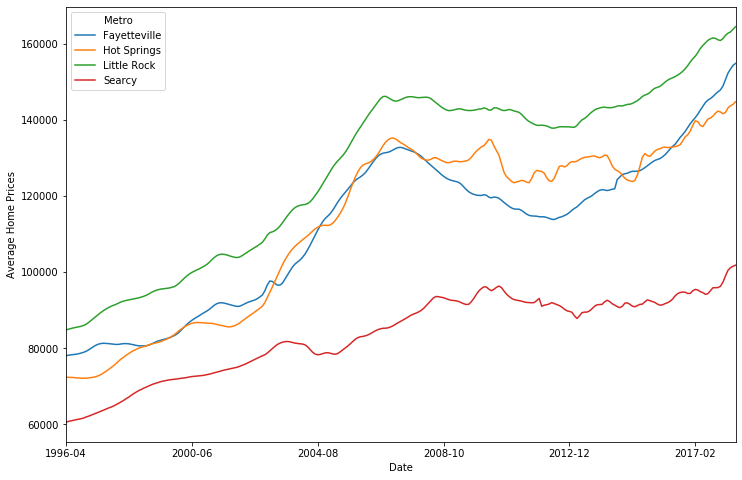

In [6]:
ax = ark.plot(figsize=(12, 8))
ax.set_ylabel('Average Home Prices')
ax.set_xlabel('Date')
plt.show()

### AVG House pricing reached the lowest point in 2012 with significant growth after 2012. 

#### Is this a national trend? needs further exploration

In [7]:
ark.shape
list(ark.columns.values)
ark.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 1996-04 to 2018-06
Data columns (total 4 columns):
Fayetteville    267 non-null float64
Hot Springs     267 non-null float64
Little Rock     267 non-null float64
Searcy          267 non-null float64
dtypes: float64(4)
memory usage: 10.4+ KB


### Preparing Fayettevile for time series analysis with prophet

In [8]:
laf = ark[['Fayetteville']]
laf = laf.loc['1997-01-01':'2017-12-01']
laf.reset_index()
laf.head()

Metro,Fayetteville
1997-02,80025.00
1997-03,80458.33
1997-04,80836.11
1997-05,81108.33
1997-06,81263.89


In [9]:
# Rename columns for prophet
laf = laf.reset_index()
laf = laf.rename(index=str, columns={"Fayetteville": "y", "index": "ds"})
laf.shape

(251, 2)

In [10]:
laf['ds'] = pd.to_datetime(laf['ds'],format='%Y-%m-%d')
laf.tail()

Metro,ds,y
246,2017-08-01,145552.63
247,2017-09-01,146094.74
248,2017-10-01,146755.26
249,2017-11-01,147339.47
250,2017-12-01,147855.26


### Buidling a prophet model

In [11]:
# MODEL FIT
# Set the uncertainty interval to 95% (the Prophet default is 80%)
laf_model = Prophet(interval_width=0.95)
laf_model.fit(laf)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future_dates = laf_model.make_future_dataframe(periods=12, freq='MS')
#future_dates.tail(12)

### Predict

In [13]:
# MODEL PREDICT
forecast = laf_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
251,2018-01-01,145702.40,143927.87,147510.31
252,2018-02-01,146225.34,144325.29,148294.37
253,2018-03-01,146804.84,144875.59,148633.81
254,2018-04-01,147291.97,145285.38,149286.11
255,2018-05-01,147787.03,145873.83,149905.74
256,2018-06-01,148319.63,146111.42,150254.37
257,2018-07-01,148976.88,146774.93,151196.47
258,2018-08-01,149519.12,147021.38,151943.01
259,2018-09-01,150084.35,147118.88,152704.11
260,2018-10-01,150620.28,147954.95,153411.94


### Model Plot

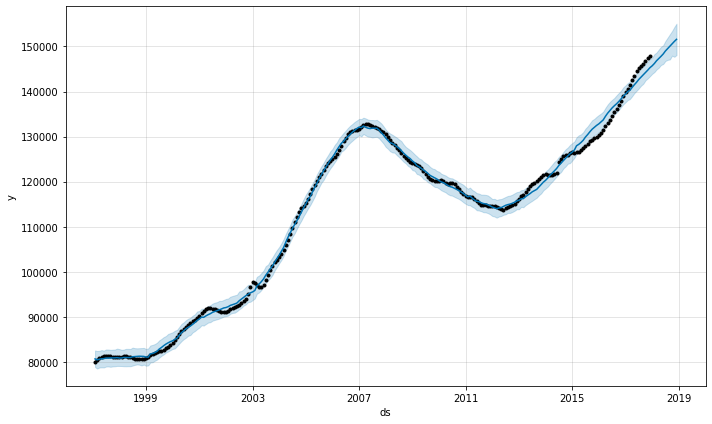

In [14]:
# MODEL PLOT
laf_model.plot(forecast, uncertainty=True);

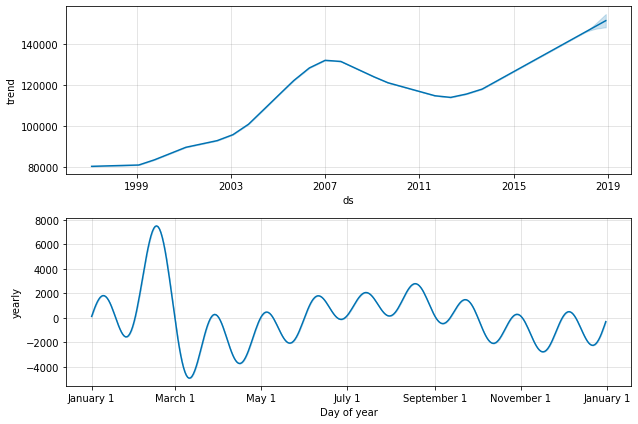

In [15]:
# INTERPRET
laf_model.plot_components(forecast);

## Expanding nationwide

#### Transforming Data to suitable format

In [16]:
# Pivot the data to have a row for each zip code
df_data = pd.pivot_table(df, values=df.iloc[:, 7:], 
                               columns=['ZipCode', 'City', 'State', 'Metro', 'CountyName',])
df_data = df_data.reset_index()
df_data.rename(columns={'level_0':'Date', 0:'Value'}, inplace=True)
df_data['Date'] = pd.to_datetime(df_data['Date'], infer_datetime_format=True)
df_data['ZipCode'] = df_data['ZipCode'].astype(object)
df_data.head()

,Date,ZipCode,City,State,Metro,CountyName,Value
0,1996-04-01,1001,Agawam,MA,Springfield,Hampden,113100.00
1,1996-04-01,1002,Amherst,MA,Springfield,Hampshire,161000.00
2,1996-04-01,1005,Barre,MA,Worcester,Worcester,103100.00
3,1996-04-01,1007,Belchertown,MA,Springfield,Hampshire,133400.00
4,1996-04-01,1008,Blandford,MA,Springfield,Hampden,117500.00


#### Printing some statistics:

In [17]:
# Print the first and last date of the data 
print('Min Date: ', df_data['Date'].min())
print('Max Date: ', df_data['Date'].max(), '\n')

# Count of Zip Codes
print('Number of zipcodes: ', len(df_data['ZipCode'].unique()),'\n')

print(df_data['State'].value_counts().head(10))

Min Date:  1996-04-01 00:00:00
Max Date:  2018-06-01 00:00:00 

Number of zipcodes:  13958 

CA    316128
NY    262995
TX    232290
PA    220275
FL    205323
OH    157797
IL    145248
NJ    134034
MI    126024
MA    111873
Name: State, dtype: int64


#### Making sure we start in 1997

In [18]:
df_data = df_data[df_data['Date'] >= '1997-01-01' ]

### Plotting Average Value for US

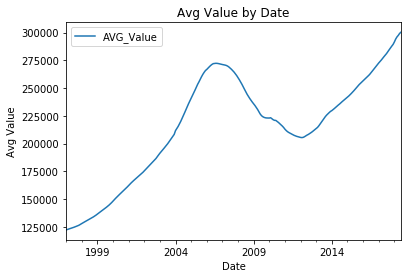

In [27]:
pd.plotting.register_matplotlib_converters()
df_us = df_data.groupby('Date')['Value'].mean().round()
df_us = df_us.reset_index()
df_us.columns = ['Date', 'AVG_Value']

# Plot the data as a line plot. 
df_us.plot(x='Date', y='AVG_Value')
_ = plt.xlabel('Date')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Date')
plt.show()

### Plotting each state in US

In [22]:
df_st = df_data.groupby(['Date', 'State'])['Value'].mean().round()
df_st = df_st.reset_index()
df_st.columns = ['Date', 'State', 'AVG_Value']
df_st_pv = df_st.pivot(index='Date', columns='State', values='AVG_Value')

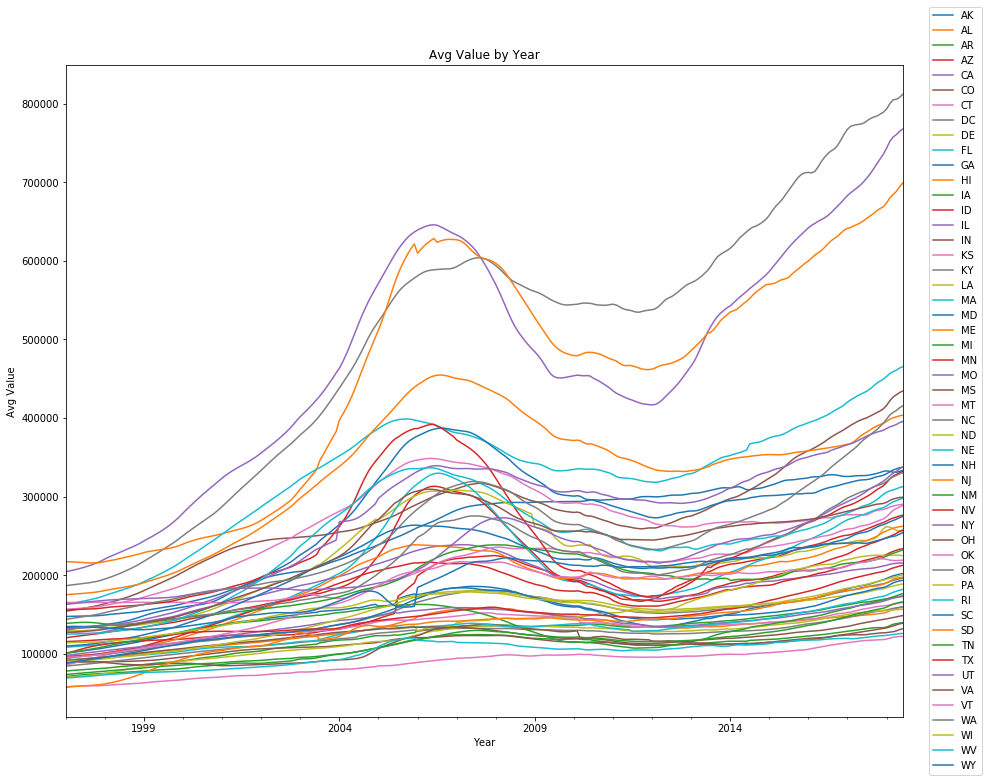

In [26]:
# Plot the data
pd.plotting.register_matplotlib_converters()
df_st_pv.plot(figsize=(15,12))
_ = plt.xlabel('Year')
_ = plt.ylabel('Avg Value')
_ = plt.title('Avg Value by Year')
plt.legend(loc='center right', bbox_to_anchor=[1.1, 0.5])
plt.show()

### Searching States with highest growth over 3-year period (2014-2017)

    1- Taking the values for December 
    2- Calculate % Growth for 3-Year period. 
    3- Sort by % growth and get the top states.

In [28]:
# Identify December observations
december = df_st['Date'].map(lambda x: x.month) == 12
df_st_dec = df_st[december]

# Calculate percent growth 3-yr perriod
df_st_dec['GrowthPerc'] = df_st_dec['AVG_Value'].div(df_st_dec.groupby('State')['AVG_Value'].shift(3))-1
df_st_dec = df_st_dec.dropna()

print(df_st_dec.sort_values(['State', 'Date'],ascending=False).head()) 

            Date State  AVG_Value  GrowthPerc
12851 2017-12-01    WY  246119.00        0.08
12239 2016-12-01    WY  240805.00        0.09
11627 2015-12-01    WY  235419.00        0.09
11015 2014-12-01    WY  226962.00        0.08
10403 2013-12-01    WY  220643.00        0.04


### States with 25% growth or more

In [29]:
Growth_3Yr = df_st_dec[df_st_dec['Date']=='2017-12-01']
print(Growth_3Yr[Growth_3Yr['GrowthPerc']>0].sort_values('GrowthPerc', ascending=False))

            Date State  AVG_Value  GrowthPerc
12848 2017-12-01    WA  393434.00        0.40
12838 2017-12-01    OR  316745.00        0.31
12834 2017-12-01    NV  313678.00        0.30
12810 2017-12-01    FL  285947.00        0.29
12806 2017-12-01    CO  411603.00        0.28
12845 2017-12-01    UT  319674.00        0.27
12805 2017-12-01    CA  735420.00        0.26
12814 2017-12-01    ID  246255.00        0.25
12843 2017-12-01    TN  158015.00        0.24
12823 2017-12-01    MI  168747.00        0.23
12844 2017-12-01    TX  204707.00        0.23
12840 2017-12-01    RI  302907.00        0.22
12841 2017-12-01    SC  184402.00        0.21
12808 2017-12-01    DC  788956.00        0.21
12811 2017-12-01    GA  194338.00        0.21
12820 2017-12-01    MA  449448.00        0.20
12804 2017-12-01    AZ  267044.00        0.20
12824 2017-12-01    MN  224895.00        0.20
12830 2017-12-01    NE  173305.00        0.20
12822 2017-12-01    ME  254592.00        0.19
12818 2017-12-01    KY  155001.00 

### Top States by growth: WA, OR, NV, FL, CO, UT, CA, ID

#### Timeseries analysis for home zip code (FL)

In [30]:
# Select a zip code to represent our data 
myhome = df_data[df_data['ZipCode']==33193]
myhome_ts = myhome[['Date', 'Value']]
myhome_ts = myhome_ts.set_index('Date')

# Separate into training and test sets
x_train = myhome_ts.loc[:'2017-12-01'].reset_index()
x_test = myhome_ts.loc['2018-01-01':].reset_index()

In [31]:
print(x_train.tail(),'\n')
print(x_test)

          Date     Value
247 2017-08-01 325400.00
248 2017-09-01 327200.00
249 2017-10-01 328600.00
250 2017-11-01 328600.00
251 2017-12-01 329600.00 

        Date     Value
0 2018-01-01 332400.00
1 2018-02-01 334800.00
2 2018-03-01 336300.00
3 2018-04-01 339000.00
4 2018-05-01 342400.00
5 2018-06-01 344200.00


### Prophet timeseries for home zip code

In [32]:
# Build prophet model with 95% confidence interval, looking at yearly seasonality with prior changepoint of 6 months and 
# seasonality change point set to 1 month. 
m1 = Prophet(interval_width=.95, 
             #changepoints=['2012-01-01'],
             changepoint_prior_scale=6, 
             yearly_seasonality=True, 
             seasonality_prior_scale=1
            )
m1.add_seasonality(name='monthly', period=120, fourier_order=4)
x_train.columns = ['ds', 'y']
m1.fit(x_train)

# Look at the next 12 months. 
future_dates = m1.make_future_dataframe(periods=12, freq='MS')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
print(future_dates.tail())

            ds
259 2018-08-01
260 2018-09-01
261 2018-10-01
262 2018-11-01
263 2018-12-01


In [34]:
# Forecast next 12 months with confidence intervals
forecast = m1.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
258,2018-07-01,350689.31,333916.69,368866.51
259,2018-08-01,353365.64,332564.38,374867.39
260,2018-09-01,355987.21,330626.51,381095.16
261,2018-10-01,358478.55,329482.36,387373.28
262,2018-11-01,360699.96,326230.18,395609.79
263,2018-12-01,362970.29,323725.74,400839.62


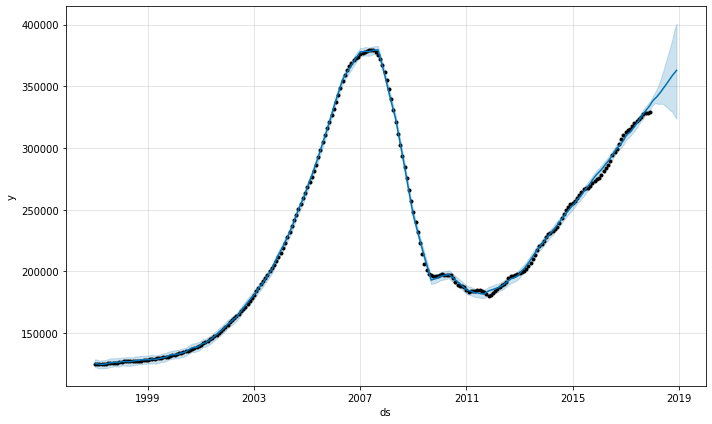

In [35]:
# Plot model with forecast trend values and uncertainty. 
m1.plot(forecast, uncertainty=True);

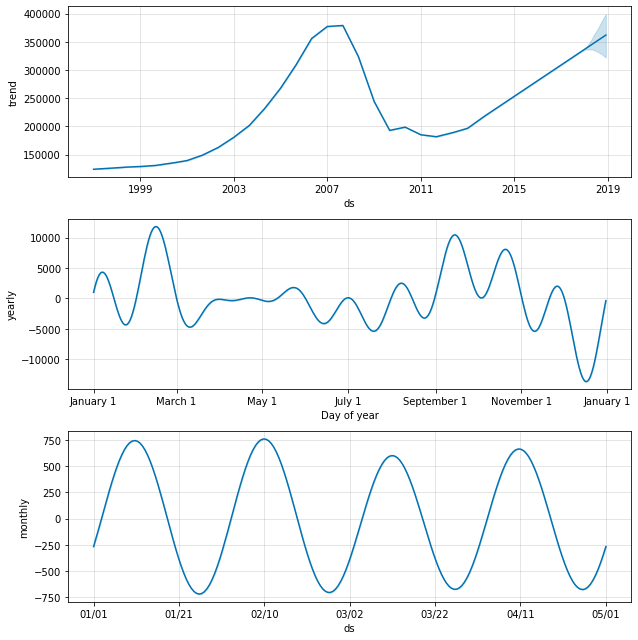

In [36]:
# Plot trend, yearly, and monthly seasonilities.
m1.plot_components(forecast);

### Calculating MSE, MAE, and R-Square Metrics

In [37]:
# MAE, MSE
mae_m1 = mean_absolute_error(x_test.Value, 
                             forecast[forecast['ds']>='2018-01-01'].yhat.head(6))
print('The Mean Absolute Error : {}'.format(round(mae_m1, 2)))

mse_m1 = mean_squared_error(x_test.Value, 
                            forecast[forecast['ds']>='2018-01-01'].yhat.head(6))
print('The Mean Squared Error : {}'.format(round(mse_m1, 2)))

r2_m1 = r2_score(x_test.Value,
                 forecast[forecast['ds']>='2018-01-01'].yhat.head(6))
print('The R-Square is {}'.format(round(r2_m1, 2)))

The Mean Absolute Error : 4526.63
The Mean Squared Error : 20920960.7
The R-Square is -0.22


## Timeseries analysis for top states:
#### FL, WA, OR, NV, FL, CO, UT,'CA, ID

In [38]:
# Filtering by the top state by growth
#top_states = ['FL','WA','OR', 'NV', 'FL', 'CO','UT','CA','ID']
#df_data = df_data[df_data['State'].isin(top_states)]
print('Number of zip codes to be analyzed: ', len(df_data['ZipCode'].unique()))
# df_data.head()

Number of zip codes to be analyzed:  13958


In [39]:
# Train / Test Split
df_model = df_data[['Date', 'Value', 'ZipCode']]
X_train = df_model[df_data['Date']<='2017-12-01']
X_train.columns = ['ds', 'y', 'ZipCode']

X_test = df_model[df_data['Date']>='2018-01-01']
X_test.columns = ['ds', 'y', 'ZipCode']

In [40]:
print(X_train.head(),'\n')
print(X_test.tail())

               ds         y ZipCode
125622 1997-01-01 111900.00    1001
125623 1997-01-01 157500.00    1002
125624 1997-01-01 105200.00    1005
125625 1997-01-01 130700.00    1007
125626 1997-01-01 116400.00    1008 

                ds         y ZipCode
3726781 2018-06-01 266800.00   99705
3726782 2018-06-01 268200.00   99709
3726783 2018-06-01 279200.00   99712
3726784 2018-06-01 413300.00   99801
3726785 2018-06-01 305700.00   99901


### Prophet function: takes a Zip Code as input 
### and fits a model with the data. Then we can use that model to predict the next 12 months.

In [41]:
# function that creates Prophet model takes a Zip Code as inoput
def run_prophet(ZipCode):
    # Filter zip
    data = X_train[X_train['ZipCode']== ZipCode][['ds', 'y']]
#     model = Prophet(interval_width=.95, 
#                     changepoint_prior_scale=6, 
#                     yearly_seasonality=True, 
#                     seasonality_prior_scale=1)
    model = Prophet(interval_width=.95)    
    
#   model.add_seasonality(name='monthly', period=120, fourier_order=4)
    model.fit(data)   
    future_dates = model.make_future_dataframe(periods=12, freq='MS')
    
    forecast = model.predict(future_dates)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    forecast_results = forecast[forecast['ds']>='2018-01-01']
    forecast_results.loc[:, 'ZipCode'] = ZipCode
    
    return(forecast_results)

#### Running the custom function in parallel

In [42]:
start_time = time.time()
forecast_df = pd.DataFrame()
zips = X_train['ZipCode'].unique()
#zips = [32003, 32009, 32011, 32024, 32025, 32033, 32034, 32038, 32040]
p = Pool(cpu_count())
result = p.map(run_prophet, zips)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_sea

In [43]:
for i in range(0, len(zips)):
    results = pd.DataFrame(result[i])
    forecast_df  = forecast_df.append(results)
   
p.close()
p.join()
print("--- %s seconds ---" % (time.time() - start_time))

--- 6048.150233745575 seconds ---


#### 1.68 Hours to process 14k Zip codes with Prophet

In [44]:
forecast_df[forecast_df['ZipCode']==32003].head(6)

,ds,yhat,yhat_lower,yhat_upper,ZipCode
252,2018-01-01,265678.89,259981.22,271300.93,32003
253,2018-02-01,266774.85,260731.63,272714.91,32003
254,2018-03-01,267834.09,261957.00,273831.17,32003
255,2018-04-01,268809.38,262051.40,275079.43,32003
256,2018-05-01,269811.81,262982.67,275614.83,32003
257,2018-06-01,270880.61,263017.76,277559.65,32003


In [45]:
X_test[X_test['ZipCode']==32003]

,ds,y,ZipCode
3648008,2018-01-01,273600.00,32003
3661966,2018-02-01,274900.00,32003
3675924,2018-03-01,275800.00,32003
3689882,2018-04-01,276800.00,32003
3703840,2018-05-01,278200.00,32003
3717798,2018-06-01,279400.00,32003


#### Fuction to calculate metrics

In [46]:
# Function to calculate metrics for each zip
def calc_metrics(ZipCode):
    # Filter zip
    zip_test = X_test[X_test['ZipCode']== ZipCode][['ds', 'y']]
    zip_fc   = forecast_df[forecast_df['ZipCode']==32003].head(6)

    mae = mean_absolute_error(zip_test.y, zip_fc.yhat)
    mse = mean_squared_error(zip_test.y, zip_fc.yhat)
    r2  = r2_score(zip_test.y, zip_fc.yhat)
    metrics = [ZipCode, mae, mse, r2]
    return(metrics)

In [47]:
print(calc_metrics(32003))

[32003, 8151.727771559507, 66501576.919523574, -16.473591483124217]


In [48]:
# Running calc_metrics for each zip code
metrics_df = pd.DataFrame(columns=['ZipCode', 'MAE', 'MSE', 'R2'])

for zc in zips:
    mdf = calc_metrics(zc)
    metrics_df  = metrics_df.append({'ZipCode': mdf[0],
                                     'MAE': mdf[1],
                                     'MSE': mdf[2],
                                      'R2': mdf[3]} , ignore_index=True)
metrics_df['ZipCode'] = metrics_df['ZipCode'].astype(object)

In [49]:
metrics_df.head()

,ZipCode,MAE,MSE,R2
0,1001.00,43864.94,1924659527.35,-1655.02
1,1002.00,90001.73,8125798151.86,-174.63
2,1005.00,46531.61,2166710776.80,-250.78
3,1007.00,5401.73,29225198.14,-8.96
4,1008.00,54064.94,2931334170.12,-146.26


#### Zip codes with lowest MSE metric for Prophet models

In [50]:
metrics_df.sort_values('MAE',ascending=True).head(10)

,ZipCode,MAE,MSE,R2
5413,33544.00,348.27,208028.24,0.95
5541,33919.00,397.02,234711.07,0.89
12515,92201.00,425.46,239758.23,0.89
497,3055.00,594.69,826811.46,0.86
6400,40222.00,600.45,675140.78,0.78
5377,33442.00,604.90,533078.32,0.87
1145,7847.00,651.73,547441.76,0.84
8447,55011.00,736.31,885068.39,0.86
7609,48360.00,744.34,838346.59,0.84
4321,28409.00,744.69,693719.87,0.87


### Calculating forecasted % growth:  2018-12-01 vs. 2017-12-01

In [51]:
# Getting Geo areas
geo = df_all[['ZipCode','City','State','Metro']]

# Getting values for 12/2017 for each zip
base = X_train[X_train['ds']=='2017-12-01'][['ZipCode','y']]

# Getting forecasted values for 12/2018 for each zip
future = forecast_df[forecast_df['ds']=='2018-12-01'][['ZipCode','yhat']]

# Getting forecast MAE for each zip
mse_df = metrics_df[['ZipCode','MSE','MAE','R2']]

In [52]:
base_geo = pd.merge(geo, base, how='inner', on='ZipCode')
merged_df = pd.merge(base_geo,future, how='inner', on='ZipCode' )
merge_full = pd.merge(merged_df,mse_df, how='inner',on='ZipCode')

print(merge_full.shape)

(13958, 9)


### Calculating 2018 %Growth 

In [53]:
merge_full['2018 Growth'] = round(merge_full['yhat']/merge_full['y']-1,2)

#### Displaying forecasted growth for home zip code

In [54]:
merge_full[merge_full['ZipCode']==33193]

,ZipCode,City,State,Metro,y,yhat,MSE,MAE,R2,2018 Growth
1839,33193,Kendall West,FL,Miami-Fort Lauderdale,329600.00,361403.68,4889701559.36,69885.06,-283.59,0.10


#### Displaying most accurate models by MAE with at least 10% growth

In [55]:
df_rec1 = merge_full.sort_values(['MAE'], ascending=[True])
df_rec1 = df_rec1[df_rec1['2018 Growth']>= .10]
df_rec1.head(10)

,ZipCode,City,State,Metro,y,yhat,MSE,MAE,R2,2018 Growth
1182,33919,Fort Myers,FL,Fort Myers,265500.00,295046.95,234711.07,397.02,0.89,0.11
7976,34987,Port Saint Lucie,FL,Port St. Lucie,265100.00,295132.52,1783296.53,1017.47,0.79,0.11
8499,20710,Bladensburg,MD,Washington,269900.00,301085.25,3582264.77,1240.82,-2.53,0.12
3036,14534,Pittsford,NY,Rochester,270200.00,302570.27,4621249.45,1963.69,-4.73,0.12
265,33063,Margate,FL,Miami-Fort Lauderdale,263200.00,290490.51,5131359.70,1994.69,0.39,0.10
10481,86324,Clarkdale,AZ,Prescott,259200.00,286755.39,6313434.41,2200.80,0.59,0.11
144,77459,Missouri City,TX,Houston,267900.00,294670.17,5424380.20,2285.06,-1.67,0.10
4283,20784,New Carrollton,MD,Washington,263600.00,292220.80,7321386.49,2414.34,0.61,0.11
6424,89433,Sun Valley,NV,Reno,258700.00,286273.57,9793524.39,2919.64,0.53,0.11
10113,33922,Bokeelia,FL,Fort Myers,255100.00,279841.46,15316321.48,3281.01,0.51,0.10


#### Displaying the highest forecasted growth with less than 20k MAE

In [56]:
df_rec2 = merge_full.sort_values(['2018 Growth'], ascending=[False])
df_rec2 = df_rec2[df_rec2['MAE']<= 30000]
df_rec2.head(10)

,ZipCode,City,State,Metro,y,yhat,MSE,MAE,R2,2018 Growth
10765,95457,Lower Lake,CA,Clearlake,238900.00,285597.63,105447988.41,6384.13,-0.05,0.20
6953,93927,Greenfield,CA,Salinas,284400.00,338098.38,683105317.26,25951.73,-28.40,0.19
5143,37216,Nashville,TN,Nashville,279000.00,328631.33,308471208.34,17535.06,-44.98,0.18
11223,32764,Mims,FL,Melbourne,248400.00,292225.09,49028717.08,5264.94,-0.29,0.18
13804,58042,Harwood,ND,Fargo,253900.00,293492.92,203042943.02,14214.94,-55.27,0.16
495,60608,Chicago,IL,Chicago,230700.00,267016.54,863474204.49,29314.94,-61.31,0.16
835,33125,Miami,FL,Miami-Fort Lauderdale,271500.00,311937.46,264574359.64,15768.39,-7.01,0.15
1475,34231,Sarasota,FL,North Port-Sarasota-Bradenton,250600.00,287762.45,300073886.29,17264.94,-329.15,0.15
7136,33955,Punta Gorda,FL,Punta Gorda,232000.00,267679.87,807824211.96,28314.94,-45.36,0.15
5354,89408,Fernley,NV,Fernley,224300.00,257371.69,872419577.78,29348.27,-34.17,0.15


In [58]:
df_rec1.to_pickle("./data/rec1.pkl")
df_rec2.to_pickle("./data/rec2.pkl")

##### Plotly graphs do not display in Jupyter Lab. Separate Notebook was created